In [19]:
# If the below code doesn't work uncomment this and run (this adds the parent directory to the path)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import numpy as np

In [67]:
from pydatastream import Datastream
import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from datetime import date, timedelta

In [4]:
dl = DataLib("SignalData")

In [6]:
LongRates = dl.pull('LongRates')
ShortRates = dl.pull('ShortRates')
BondReturnIndex = dl.pull('BondRetIdx/LocalFX')

# Indicators

#### 1. Money Supply (M1, M2, and/or M3 [for US])
    

#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Claim: 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Growth in the monetary base over the past X months compared to the past 1 year is indicative of a higher propensity for increased inflation. The inflation &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; will erode returns of bonds and lead to raised interest rates. 

#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Parameters to test: 
<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Type of Money Supply: M1, M2, M3
    <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Countries
    <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Size of window to determine growth of monetary base: 3 months, 6 months, 9 months

#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Considerations: 
<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Industrial production
    <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Spending
    <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Consumer/producer price index

#### 2.

In [910]:
#returns time-series data of daily, cumulative profits/losses
def pnl_series(signals, bankroll, country, start=0, end=0):
    
    #if signals data is monthly and not daily
    BondReturnIndex = dl.pull('BondRetIdx/LocalFX')[country]
    BondReturnIndex = BondReturnIndex.to_frame("return")

    BondReturnIndex["daily_change"] = np.exp(np.log(BondReturnIndex["return"]).diff(1))
    BondReturnIndex["full-date"] = BondReturnIndex.index.to_series().astype(str)
    BondReturnIndex["year-month"] = BondReturnIndex['full-date'].str.slice(0, 7)

    merged = BondReturnIndex.set_index("year-month").join(signals[['year-month', "signal"]].set_index("year-month"), on="year-month", how='left', lsuffix="-og")
    merged["signal"] = merged["signal"].shift(44)

    merged['net_for_day'] = merged['signal'] * (merged['daily_change']-1) * bankroll #calculation
    merged = merged.set_index("full-date")
    
    cumulative = merged["net_for_day"].cumsum()

    return cumulative, merged

#plots PNL vs BondReturnIndex
def plot_pnl(pnl_values, indicator, table, country):
    table = table["return"]
    first_val = table.first_valid_index()
    table = table.fillna(0)
    table = table - table[first_val]
    #table = table.set_index("full-date")
    
    pnl_values = pnl_values.to_frame().set_index(pd.to_datetime(pnl_values.index))
    
    fig, ax1 = plt.subplots()
    ax1_label = 'Profit and Loss'
    ax1.plot(pnl_values, label = indicator)
    ax1.set_ylabel(ax1_label)
    ax1.plot(table, color = 'tab:red', label = "Bond Return Index")
    ax1.legend()
    plt.title("{0} vs Bond Return Index".format(indicator+" " + country))
    plt.show()     

    
#use later - plotting in general
def plot(item, start=0, end=0, countries=0):
    ticker = dl.pull(item)
    selected = 0
    if start and end:
        if not countries:
            selected = ticker.loc[pd.Period(start):pd.Period(end)]
        else:
            selected = ticker.loc[pd.Period(start):pd.Period(end), countries]
    else:
        if not countries:
            selected = ticker
        else:
            selected = ticker[countries]
    selected.plot()
    

class Indicator:
    #returns time series data from -1 to 1, for each day from "start" to "end" of the decision based on monetary supply
    
    def __init__(self, country, weights):
        self.country = country
        self.weights = weights
    
    def monetary_supply_indicator(self, m):
        m2 = dl.pull(m+"/inUSD")[self.country]
        m2 = m2.to_frame("supply")
        
        m2["year-month"] = m2.index.to_series().astype(str)
        m2["diff_3"] = np.exp(np.log(m2["supply"]).diff(3))
        m2["diff_12"] = np.exp(np.log(m2["supply"]).diff(12))
        m2["signal"] = np.where(m2['diff_12'] < m2['diff_3'], -1, 1) #work on magnitude of difference from mean; farther away from difference = confidence
        return m2
    
    def always_constant(self, x):
        m2 = dl.pull("M2/inUSD")[self.country]
        m2 = m2.to_frame("supply")
        
        m2["year-month"] = m2.index.to_series().astype(str)
        m2["diff_3"] = np.exp(np.log(m2["supply"]).diff(3))
        m2["diff_12"] = np.exp(np.log(m2["supply"]).diff(12))
        m2["signal"] = x
        return m2

    #use later to combine MULTIPLE indicators
    def signals(self,selected_indicators):
        indicators = selected_indicators()
        final_signals = []

        for day in all_dates:
            final_signal = 0
            for i in range(1):
                final_signal = indicators[i]*self.weights[i]
            final_signals.append(final_signal)

        return final_signals

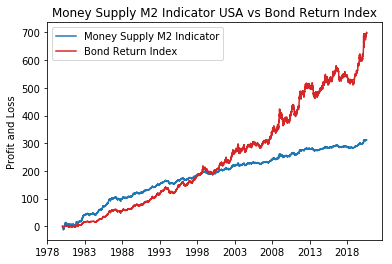

In [907]:
a = Indicator("USA", [1])
signals = a.monetary_supply_indicator("M2")
pnl_values, table = pnl_series(signals, 100, "USA")
plot_pnl(pnl_values, "Money Supply M2 Indicator", table, "USA")

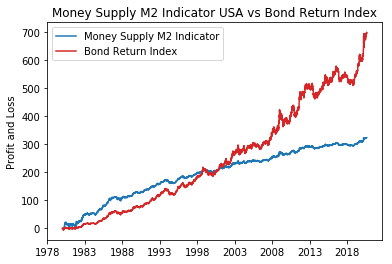

In [909]:
a = Indicator("USA", [1])
signals = a.monetary_supply_indicator("M2")
pnl_values, table = pnl_series(signals, 100, "USA")
plot_pnl(pnl_values, "Money Supply M2 Indicator", table, "USA")

374.058


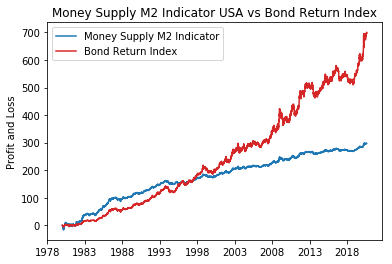

189.125


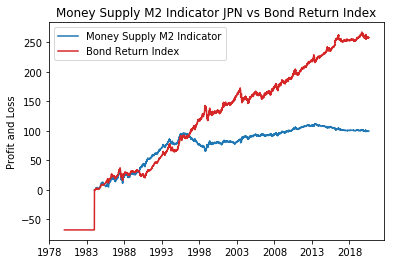

504.366


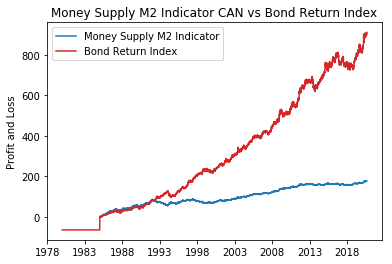

416.423


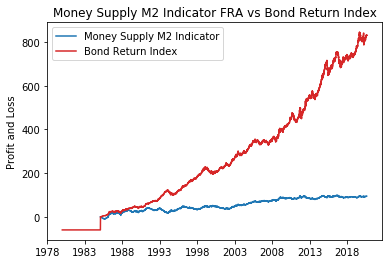

In [905]:
countries = ['USA', 'JPN', 'CAN','FRA']
for country in countries:
    a = Indicator(country, [1])
    signals = a.monetary_supply_indicator("M2")
    pnl_values, table = pnl_series(signals, 100, country)
    plot_pnl(pnl_values, "Money Supply M2 Indicator", table,country)

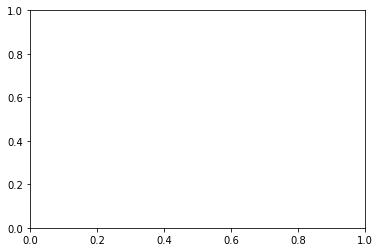

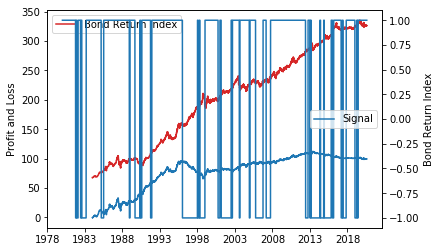

In [758]:
a = Indicator(country, [1])
signals = a.monetary_supply_indicator("M2")
pnl_values, table = pnl_series(signals, 100, country)
pnl_values = pnl_values.to_frame().set_index(pd.to_datetime(pnl_values.index))
signal = table["signal"]
signal = signal.to_frame().set_index(pd.to_datetime(pnl_values.index))

fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Profit and Loss'
ax1.plot(pnl_values)
ax1.set_ylabel(ax1_label)
ax1.plot(BondReturnIndex[country].to_timestamp(), color = 'tab:red', label = "Bond Return Index")
ax1.legend()
ax2.label = "Signal Value"
ax2.plot(signal, label = "Signal")
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.show()    

416.423


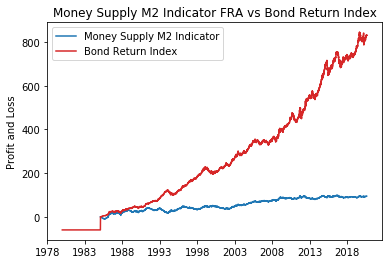

374.058


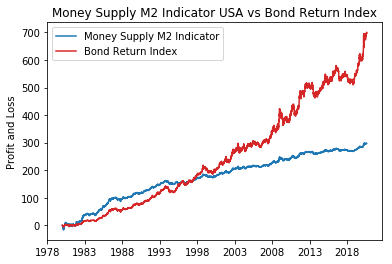

189.125


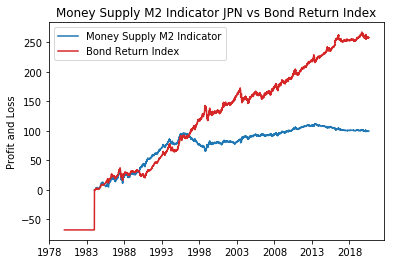

504.366


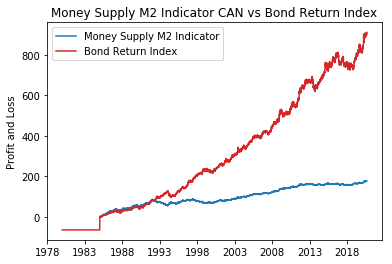

In [902]:
countries = ['FRA','USA', 'JPN', 'CAN']
for country in countries:
    a = Indicator(country, [1])
    signals = a.monetary_supply_indicator("M2")
    pnl_values, table = pnl_series(signals, 100, country)
    plot_pnl(pnl_values, "Money Supply M2 Indicator", table, country)

In [815]:
BondReturnIndex = dl.pull('BondRetIdx/LocalFX')["USA"]
#BondReturnIndex = BondReturnIndex-3
BondReturnIndex[0]

37.527

In [833]:
BondReturnIndex = dl.pull('BondRetIdx/LocalFX')["USA"]
#BondReturnIndex = BondReturnIndex.to_frame("return")

np.isnan(BondReturnIndex[0])

False

In [844]:
BondReturnIndex = dl.pull('BondRetIdx/LocalFX')["USA"]
first_val = BondReturnIndex.first_valid_index()
BondReturnIndex = BondReturnIndex.fillna(0)
BondReturnIndex = BondReturnIndex - BondReturnIndex[first_val]
BondReturnIndex

date
1980-01-01      0.000
1980-01-02     -0.371
1980-01-03     -0.586
1980-01-04     -0.668
1980-01-07     -0.601
1980-01-08     -0.466
1980-01-09     -0.466
1980-01-10     -0.310
1980-01-11     -0.649
1980-01-14     -0.684
1980-01-15     -0.561
1980-01-16     -0.551
1980-01-17     -0.663
1980-01-18     -0.880
1980-01-21     -1.150
1980-01-22     -0.914
1980-01-23     -0.837
1980-01-24     -1.232
1980-01-25     -1.391
1980-01-28     -1.492
1980-01-29     -1.595
1980-01-30     -1.495
1980-01-31     -1.415
1980-02-01     -1.712
1980-02-04     -1.937
1980-02-05     -2.579
1980-02-06     -2.942
1980-02-07     -2.513
1980-02-08     -2.640
1980-02-11     -3.057
               ...   
2020-06-23    687.466
2020-06-24    689.189
2020-06-25    689.885
2020-06-26    692.432
2020-06-29    692.558
2020-06-30    691.429
2020-07-01    689.388
2020-07-02    690.199
2020-07-03    690.235
2020-07-06    689.334
2020-07-07    691.857
2020-07-08    690.045
2020-07-09    693.359
2020-07-10    691.460
2020-